# Using built-in training and evaluation loops
## Customizing the workflow
- Provide your own custom metrics  
- Pass callbacks to the fit() method to schedule actions to be taken at specific points during training

## 7.3.1 Writing your own metrics

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")
    
    #Implement the state update logic in update_state()
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
    
    #Return value
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
    
    #Reinstantiate
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [19]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model


(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255 
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255 
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]


model = get_mnist_model()
model.compile(optimizer="rmsprop",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))

test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2959 - accuracy: 0.9121 - rmse: 7.1805 - val_loss: 0.1559 - val_accuracy: 0.9565 - val_rmse: 7.3525
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1658 - accuracy: 0.9537 - rmse: 7.3536 - val_loss: 0.1321 - val_accuracy: 0.9646 - val_rmse: 7.4044
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.1016 - accuracy: 0.9733 - rmse: 7.4303


## 7.3.2 Using callbacks
A callbakc is an object that is passed to the model in the call to fit() and that is called by the model at various points during training.  
Examples of ways to use callbacks   
- Model checkpointing  
- Early stopping  
- Dynamically adjusting the value of certain parameters during training  
- Logging training and validation metrics during training, or visualizing the representations learned by the model as they’re updated—The fit() progress bar that you’re familiar with is in fact a callback!  

## ModelCheckpoint & EarlyStopping

In [27]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor = "val_accuracy",
        patience = 2, #Interrupts training when accuracy has stopped improving for two epochs
    ),
    
    #These two arguments mean you won’t overwrite the model file 
    #unless val_loss has improved, which allows you to keep the best model seen during training.
    keras.callbacks.ModelCheckpoint(
        filepath = "checkpoint_path.keras",
        monitor = "val_loss",
        save_best_only = True,
    )
]

In [25]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2933 - accuracy: 0.9128 - val_loss: 0.1454 - val_accuracy: 0.9605
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1655 - accuracy: 0.9536 - val_loss: 0.1213 - val_accuracy: 0.9656
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1378 - accuracy: 0.9626 - val_loss: 0.1175 - val_accuracy: 0.9703
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1253 - accuracy: 0.9677 - val_loss: 0.1078 - val_accuracy: 0.9731
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1160 - accuracy: 0.9702 - val_loss: 0.1051 - val_accuracy: 0.9761
Epoch 6/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1101 - accuracy: 0.9733 - val_loss: 0.1018 - val_accuracy: 0.9777
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1058 - accuracy: 0.9757 - val_loss: 0.1159 - val_accuracy:

In [26]:
model = keras.models.load_model("checkpoint_path.keras")

## 7.3.3 Writing your own callbacks

In [29]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
    
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))
        
    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.2967 - accuracy: 0.9135 - val_loss: 0.1484 - val_accuracy: 0.9567
Epoch 2/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1665 - accuracy: 0.9535 - val_loss: 0.1210 - val_accuracy: 0.9658
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1402 - accuracy: 0.9623 - val_loss: 0.1199 - val_accuracy: 0.9702
Epoch 4/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1247 - accuracy: 0.9667 - val_loss: 0.1146 - val_accuracy: 0.9727
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1193 - accuracy: 0.9693 - val_loss: 0.1058 - val_accuracy: 0.9745
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1106 - accuracy: 0.9722 - val_loss: 0.1125 - val_accuracy: 0.9756
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1070 - accuracy: 0.9743 - val_loss: 0.1053 - val_accuracy:

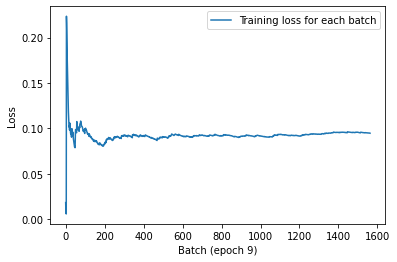

In [30]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))


In [34]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(
    log_dir="/aiffel/aiffel/AIFEL_Quest/DL_with_python/ch_07/full_path_to_your_log_dir"
)
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[tensorboard],
          validation_data=(val_images, val_labels))


Epoch 1/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2951 - accuracy: 0.9137 - val_loss: 0.1459 - val_accuracy: 0.9581
Epoch 2/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1651 - accuracy: 0.9536 - val_loss: 0.1189 - val_accuracy: 0.9677
Epoch 3/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1394 - accuracy: 0.9627 - val_loss: 0.1092 - val_accuracy: 0.9716
Epoch 4/10
1563/1563 [==============================] - 4s 2ms/step - loss: 0.1253 - accuracy: 0.9677 - val_loss: 0.1192 - val_accuracy: 0.9706
Epoch 5/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1165 - accuracy: 0.9711 - val_loss: 0.1074 - val_accuracy: 0.9770
Epoch 6/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1103 - accuracy: 0.9738 - val_loss: 0.1128 - val_accuracy: 0.9760
Epoch 7/10
1563/1563 [==============================] - 4s 3ms/step - loss: 0.1064 - accuracy: 0.9751 - val_loss: 0.1128 - val_accuracy: